In [1]:
import argparse
import time

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage.morphology import binary_dilation

import torch
from tqdm import tqdm
from dataset import get_train_test_loaders
import segmentation_models_pytorch as smp
from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils import BCE_dice, EarlyStopping, dice_pytorch, iou_pytorch, plot_result, plot_score, save_test_samples, set_seed


/tmp/ipykernel_311795/3076382974.py:6: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
SEED=42
set_seed(SEED)

In [4]:
# load model
model = smp.Unet(encoder_name="efficientnet-b7", 
                    encoder_weights="imagenet",
                    in_channels=3, 
                    classes=1,
                    activation='sigmoid')
model.to(device);
print(f"---> loaded model:")
print(model)
loss_fn = BCE_dice

---> loaded model:
Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Co

In [5]:
# load state dict to the model
model.load_state_dict(torch.load("weights/lgg-mri-segmentation.pth"))
model.to(device)

/tmp/ipykernel_311795/2547580844.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("weights/lgg-mri-segmentation.pth"))


Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [10]:
df_tumor = os.listdir('datasets/CT/1/brain_tumor_dataset/Tumor') 
# Checking class balance
arrtumor = np.array(df_tumor)

print(f"Number of tumor samples: {arrtumor.shape[0]}")

Number of tumor samples: 155


In [7]:
# Load the images from the dataset and create dataloader
from torch.utils.data import Dataset, DataLoader

class BrainTumorCTDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.images[idx])
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
            
        return image

from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = BrainTumorCTDataset('datasets/CT/1/brain_tumor_dataset/Tumor', transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


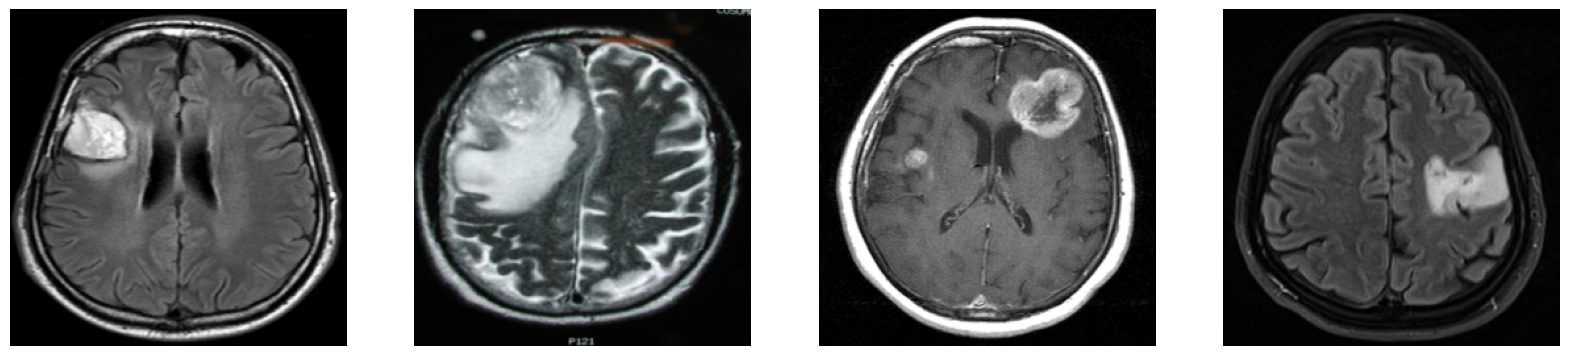

In [9]:
# Loop through the dataloader to get the images
for idx, image in enumerate(dataloader):
    if idx == 1:
        break

    fig, axes = plt.subplots(1, 4, figsize=(20, 20))
    for i in range(4):
        axes[i].imshow(image[i].permute(1, 2, 0))
        axes[i].axis('off')
    plt.show()

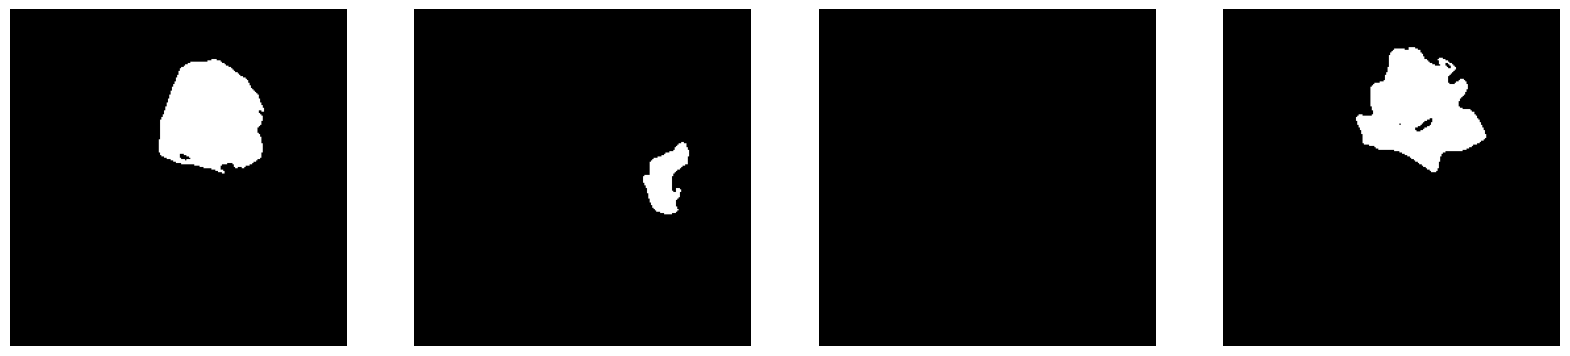

In [11]:
# Test the model on the images
model.eval()
for idx, image in enumerate(dataloader):
    if idx == 1:
        break

    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        output = (output > 0.5).float()
        
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))
    for i in range(4):
        axes[i].imshow(output[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import binary_dilation
import torch
import os
import numpy as np

def show_or_save_masks(model, test_loader, device, parent_path='', save_path=None):
    width = 3
    columns = 10
    n_examples = columns * width

    fig, axs = plt.subplots(columns, width, figsize=(7 * width, 7 * columns), constrained_layout=True)
    fig.legend(
        loc='upper right',
        handles=[
            mpatches.Patch(color='red', label='Ground truth (if available)'),
            mpatches.Patch(color='green', label='Predicted abnormality'),
        ]
    )
    i = 0
    with torch.no_grad():
        for data in test_loader:
            image = data
            # mask = mask[0]
            mask = None
            image = image.to(device)
            prediction = model(image).to('cpu')[0][0]
            prediction = torch.where(prediction > 0.5, 1, 0).numpy()

            # Prepare the base layer: Original image
            base_image = image[0].to('cpu').permute(1, 2, 0).numpy()

            # Create an alpha mask based on the prediction
            alpha_mask = np.zeros_like(prediction, dtype=np.float32)
            alpha_mask[prediction > 0] = 0.4  # Full opacity for the prediction
            alpha_mask[prediction <= 0] = 0.0  # Full transparency for areas outside

            if mask is not None and mask.byte().any():  # If ground truth is available
                prediction_edges = prediction - binary_dilation(prediction)
                ground_truth = mask - binary_dilation(mask)

                # Overlay ground truth in red
                base_image[:, :, 0][ground_truth.bool()] = 1

                # Overlay prediction edges in green
                base_image[:, :, 1][prediction_edges.bool()] = 1

                axs[i // width][i % width].imshow(base_image)
            else:  # If no ground truth is available
                axs[i // width][i % width].imshow(base_image, alpha=0.8, cmap='gray')
                axs[i // width][i % width].imshow(prediction, cmap='Oranges', alpha=alpha_mask)
                axs[i // width][i % width].set_title("Predicted Mask")

            if n_examples == i + 1:
                break
            i += 1

    # Show or save the figure
    if save_path:
        os.makedirs(parent_path, exist_ok=True)
        plt.savefig(f"{parent_path}/{save_path}")
    else:
        plt.show()

    plt.close(fig)


In [13]:
# save_test_samples(model, dataloader, device, parent_path="eval_results/CT")
show_or_save_masks(model, dataloader, device, parent_path="eval_results/CT", save_path="predicted_masks_02.png")

## Evaluation for MRI Images

In [14]:
from glob import glob
import os
import random

import numpy as np
from sklearn.impute import SimpleImputer
import torch
from skimage.io import imread

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import albumentations as A

import cv2
import pandas as pd
import matplotlib.pyplot as plt

from utils import crop_sample, pad_sample, resize_sample, normalize_volume
from sklearn.model_selection import train_test_split

def get_file_row(path):
    """Produces ID of a patient, image and mask filenames from a particular path"""
    path_no_ext, ext = os.path.splitext(path)
    filename = os.path.basename(path)
    
    patient_id = '_'.join(filename.split('_')[:3]) # Patient ID in the csv file consists of 3 first filename segments
    
    return [patient_id, path, f'{path_no_ext}_mask{ext}']

class MriDataset(Dataset):
    def __init__(self, df, transform=None, mean=0.5, std=0.25):
        super(MriDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.mean = mean
        self.std = std
        
        
    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx, raw=False):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_filename'], cv2.IMREAD_UNCHANGED)
        mask = cv2.imread(row['mask_filename'], cv2.IMREAD_GRAYSCALE)
        if raw:
            return img, mask
        
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            image, mask = augmented['image'], augmented['mask']
        
        img = T.functional.to_tensor(img)
        mask = mask // 255
        mask = torch.Tensor(mask)
        return img, mask

# load the MRI datasets
def get_train_test_loaders(batch_size=64, test_batch_size=256, num_workers=54):
    files_dir = 'datasets/2/lgg-mri-segmentation/kaggle_3m/'
    file_paths = glob(f'{files_dir}/*/*[0-9].tif')
    
    csv_path = 'datasets/2/lgg-mri-segmentation/kaggle_3m/data.csv'
    df = pd.read_csv(csv_path)

    # df.info()
    imputer = SimpleImputer(strategy="most_frequent")
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # merge original df and filenames based on patient
    filenames_df = pd.DataFrame((get_file_row(filename) for filename in file_paths), columns=['Patient', 'image_filename', 'mask_filename'])
    df = pd.merge(df, filenames_df, on="Patient")

    # ### Split data into train, valid, and test
    train_df, test_df = train_test_split(df, test_size=0.3)
    test_df, valid_df = train_test_split(test_df, test_size=0.5)


    transform = A.Compose([
        A.ChannelDropout(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.ColorJitter(p=0.3),
    ])

    train_dataset = MriDataset(train_df, transform)
    valid_dataset = MriDataset(valid_df)
    test_dataset = MriDataset(test_df)


    # ### DataLoaders

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
    
    return train_loader, valid_loader, test_loader


In [16]:
train_loader, valid_loader, test_loader = get_train_test_loaders()
print(f"Train: {len(train_loader.dataset)} samples")
print(f"Valid: {len(valid_loader.dataset)} samples")
print(f"Test: {len(test_loader.dataset)} samples")

Train: 2750 samples
Valid: 590 samples
Test: 589 samples


In [ ]:
import gui
import SimpleITK as sitk

# Function to load data by paths and plot the images
def load_images(image_paths=[], dtype=sitk.sitkInt8):
    # Load the images
    images = []
    for image_path in image_paths:
        # check format of image whether it is .nrrd or .png
        if image_path.endswith(".nrrd"):
            image = sitk.ReadImage(image_path, imageIO="NrrdImageIO")   # fetch data from the path
        elif image_path.endswith(".jpg"):
            image = sitk.ReadImage(image_path, imageIO="JPEGImageIO")
        elif image_path.endswith(".tif"):
            image = sitk.ReadImage(image_path, imageIO="TIFFImageIO", outputPixelType=dtype)
        # image = sitk.ReadImage(image_path)
        # plt.imshow(sitk_to_numpy(image), cmap="gray")
        # plt.axis("off")
        images.append(image)
    return images

def disp_images(images, fig_size, wl_list=None):
    if images[0].GetDimension() == 2:
        gui.multi_image_display2D(
            image_list=images, figure_size=fig_size, window_level_list=wl_list
        )
    else:
        gui.MultiImageDisplay(
            image_list=images, figure_size=fig_size, window_level_list=wl_list
        )


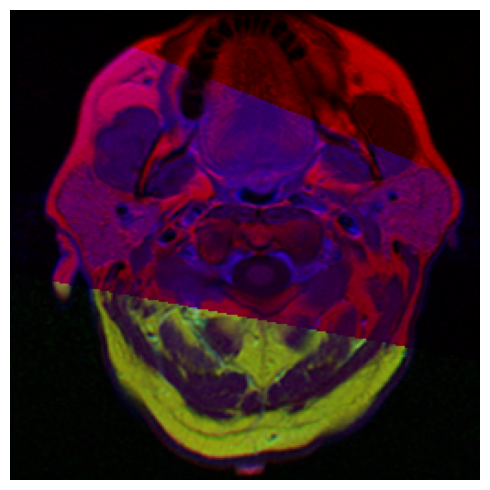

In [32]:
image_paths = ['datasets/2/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif']
images = load_images(image_paths, dtype=sitk.sitkInt8)
disp_images(images, (5, 5))

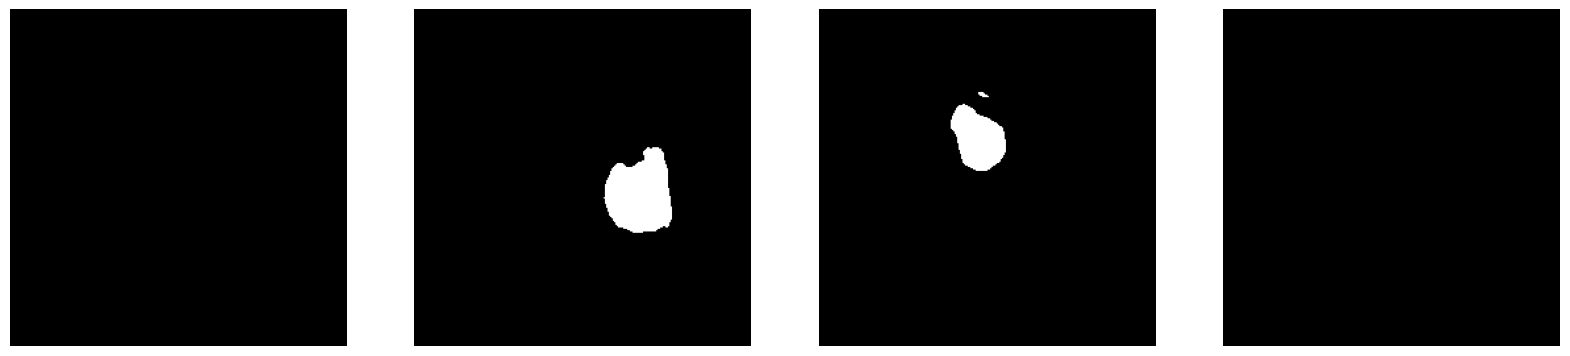

In [ ]:
# Test the model on the images
model.eval()
for idx, (image, mask) in enumerate(test_loader):
    if idx == 1:
        break
    
    image = image.to(device)
    with torch.no_grad():
        output = model(image)
        output = (output > 0.5).float()
        
    fig, axes = plt.subplots(1, 4, figsize=(20, 20))
    for i in range(4):
        axes[i].imshow(output[i].squeeze().cpu().numpy(), cmap='gray')
        axes[i].axis('off')
    plt.show()

In [39]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import binary_dilation
import torch
import os
import numpy as np

def show_or_save_masks_labeled(model, test_loader, device, parent_path='', save_path=None):
    width = 3
    columns = 10
    n_examples = columns * width

    fig, axs = plt.subplots(columns, width, figsize=(7 * width, 7 * columns), constrained_layout=True)
    fig.legend(
        loc='upper right',
        handles=[
            mpatches.Patch(color='red', label='Ground truth (if available)'),
            mpatches.Patch(color='green', label='Predicted abnormality'),
        ]
    )
    i = 0
    with torch.no_grad():
        for data in test_loader:
            image, mask = data
            print(f"shape of image: {image.shape}")
            print(f"shape of mask: {mask.shape}")
            mask = mask[0]
            # mask = None
            image = image.to(device)
            prediction = model(image).to('cpu')[0][0]
            prediction = torch.where(prediction > 0.5, 1, 0).numpy()

            # Prepare the base layer: Original image
            base_image = image[0].to('cpu').permute(1, 2, 0).numpy()

            # Create an alpha mask based on the prediction
            alpha_mask = np.zeros_like(prediction, dtype=np.float32)
            alpha_mask[prediction > 0] = 0.4  # Full opacity for the prediction
            alpha_mask[prediction <= 0] = 0.0  # Full transparency for areas outside

            if mask is not None and mask.byte().any():  # If ground truth is available
                prediction_edges = prediction - binary_dilation(prediction)
                ground_truth = mask - binary_dilation(mask)

                # Overlay ground truth in red
                base_image[:, :, 0][ground_truth.bool()] = 1

                # Overlay prediction edges in green
                base_image[:, :, 1][prediction_edges.bool()] = 1

                axs[i // width][i % width].imshow(base_image)
            else:  # If no ground truth is available
                axs[i // width][i % width].imshow(base_image, alpha=0.8, cmap='gray')
                axs[i // width][i % width].imshow(prediction, cmap='Oranges', alpha=alpha_mask)
                axs[i // width][i % width].set_title("Predicted Mask")

            if n_examples == i + 1:
                break
            i += 1

    # Show or save the figure
    if save_path:
        os.makedirs(parent_path, exist_ok=True)
        plt.savefig(f"{parent_path}/{save_path}")
    else:
        plt.show()

    plt.close(fig)

In [42]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import binary_dilation
import torch

def save_all_test_samples(model, test_loader, device, parent_path='', save_path="test_samples.png"):
    samples = []
    with torch.no_grad():
        for data in test_loader:
            image, mask = data
            mask = mask[0]
            if not mask.byte().any():  # Skip if there's no mask
                continue
            image = image.to(device)
            prediction = model(image).to('cpu')[0][0]
            prediction = torch.where(prediction > 0.5, 1, 0)
            prediction_edges = prediction - binary_dilation(prediction)
            ground_truth = mask - binary_dilation(mask)

            # Modify the image for visualization
            image[0, 0, ground_truth.bool()] = 1
            image[0, 1, prediction_edges.bool()] = 1

            samples.append(image[0].to('cpu').permute(1, 2, 0))  # Append the image for later plotting

    # Dynamically calculate rows and columns
    n_samples = len(samples)
    columns = 3  # Number of columns per row
    rows = (n_samples + columns - 1) // columns  # Calculate the number of rows

    # Plot all samples
    fig, axs = plt.subplots(rows, columns, figsize=(7 * columns, 7 * rows), constrained_layout=True)
    axs = axs.ravel()  # Flatten the axes for easy iteration

    for i, sample in enumerate(samples):
        axs[i].imshow(sample)
        axs[i].axis('off')

    # Hide unused axes
    for j in range(len(samples), len(axs)):
        axs[j].axis('off')

    # Add a legend to the figure
    fig.legend(
        loc='upper right',
        handles=[
            mpatches.Patch(color='red', label='Ground truth'),
            mpatches.Patch(color='green', label='Predicted abnormality'),
        ]
    )

    # Save the figure to the specified path
    plt.savefig(f"{parent_path}/{save_path}")
    plt.close


In [ ]:
# show_or_save_masks_labeled(model, test_loader, device, parent_path="eval_results/CT")
save_all_test_samples(model, test_loader, device, parent_path="eval_results/CT", save_path="all_test_samples_MRI.png")